<a href="https://colab.research.google.com/github/junhye00n/computer-vision/blob/master/CIFAR_10_dataset_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
# 빠른 가속을 위해 런타임을 GPU로 변경

In [109]:
pip install torchmetrics

In [110]:
import torch    # 파이토치 라이브러리를 가져옴
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchmetrics.classification import Accuracy
from collections import defaultdict    # Add this import for defaultdict
import matplotlib.pyplot as plt



Files already downloaded and verified
Files already downloaded and verified
Epoch 1

**************************************
loss: 2.300907, acc: 0.109375 [    0/50000]
loss: 1.881120, acc: 0.289062 [12800/50000]
loss: 1.892819, acc: 0.335938 [25600/50000]
loss: 1.834110, acc: 0.304688 [38400/50000]
val accuracy= 36.38251721858978 

Epoch 2

**************************************
loss: 1.748060, acc: 0.312500 [    0/50000]
loss: 1.648408, acc: 0.367188 [12800/50000]
loss: 1.810462, acc: 0.406250 [25600/50000]
loss: 1.719815, acc: 0.398438 [38400/50000]
val accuracy= 40.98101258277893 

Epoch 3

**************************************
loss: 1.621206, acc: 0.398438 [    0/50000]
loss: 1.564704, acc: 0.421875 [12800/50000]
loss: 1.736313, acc: 0.406250 [25600/50000]
loss: 1.631439, acc: 0.414062 [38400/50000]
val accuracy= 44.23457384109497 

Epoch 4

**************************************
loss: 1.541137, acc: 0.437500 [    0/50000]
loss: 1.498464, acc: 0.460938 [12800/50000]
loss: 1.649320

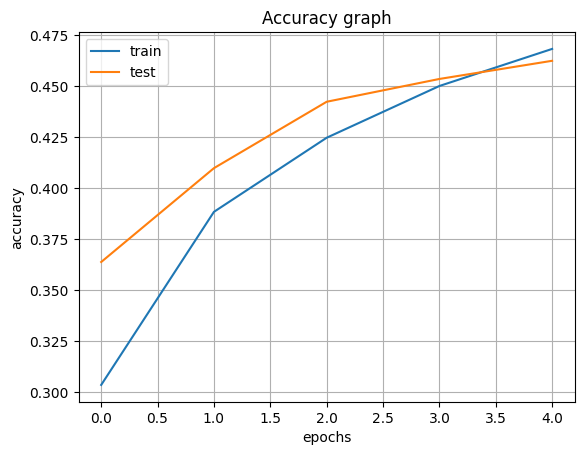

In [111]:
class SequentialModel(nn.Module):
    def __init__(self):
        super().__init__()    # 층 뒤에 ReLU 활성함수를 배치
        self.reshape = nn.Flatten()    # 다차원 입력을 1차원으로 펼침
        self.model = nn.Sequential(
            nn.Linear(3072, 1024),    # 3072개의 입력을 받아 1024개의 출력을 생성
            nn.ReLU(), #RELU 사용
            nn.Linear(1024, 512),    # 1024개의 출력을 받아 512개의 출력을 생성
            nn.ReLU(),
            nn.Linear(512, 512),    # 512개의 입력을 받아 512개의 출력 생성
            nn.ReLU(),
            nn.Linear(512, 10),    # 512개의 입력을 받아 10개의 출력 생성
        )

    def forward(self, x):
        x = self.reshape(x)    # 입력을 1차원으로 펼침
        x = self.model(x)    # 펼쳐진 x를 순차적으로 정의된 레이어에 통과
        return x    # x 값 반환



# 모델 학습
def training_epoch(dataloader, device, model, loss_fn, optimizer, metric):
    size = len(dataloader.dataset) # 데이터셋의 크기를 저장
    num_batches = len(dataloader) # 배치의 총 개수 저장
    total_loss = 0    # 손실함수를  초기화
    acc_list = []    # 리스트 초기화
    model.train()        # 모델 학습
    for batch, (x, y) in enumerate(dataloader): # 데이터로더로부터 배치를 가져옴
        x = x.to(device)    # x 전송
        y = y.to(device)    # y 전송

        y_hat = model(x)    # 모델에 입력을 전달
        loss = loss_fn(y_hat, y)    # 예측과 실제 레이블 간의 손실 계산
        total_loss += loss.item()    # 현재 배치의 손실을 누적
        acc = metric(y_hat, y)    # 정확도 계산
        acc_list.append(acc)    # 정확도를 리스트에 추가

        optimizer.zero_grad()    # 이전 배치의 그래디언트 초기화
        loss.backward()    # 현재 배치의 손실에 대한 그래디언트 계산
        optimizer.step()    # 옵티마이저를 사용해 파라이터 업데이트

        # 매 배치마다 현재 손실과 정확도 출력
        if batch % 100 == 0:
            loss = loss.item()
            current = batch * len(x)
            print(f"loss: {loss:>7f}, acc: {acc:>7f} [{current:>5d}/{size:>5d}]")

    total_loss /= num_batches    # 평균 손실 계산
    mean_acc = torch.tensor(acc_list).to(device).mean().item()    # 현재 에포크에서의 평균 정확도 계산
    return total_loss, mean_acc    # 정확도와 손실 리스트 반환

# 검증 데이터 손실 계산
def validation(dataloader, device, model, loss_fn, metric):
    num_batches = len(dataloader)
    total_loss = 0    # 현 에포크에서 사용되는 배치의 총 개수 저장실 초기화
    acc_list = []    # 정확도 초기화
    model.eval()    # 평가 모드로 설정
    with torch.no_grad():    # 평가에서는 그래디언트 계산 필요 없음
        for x, y in dataloader:
            x = x.to(device)    # x 전송
            y = y.to(device)    # y 전송

            y_hat = model(x) # 입력 후 예측
            loss = loss_fn(y_hat, y)    # 손실 계산
            total_loss += loss.item()    # 손실 누적
            acc = metric(y_hat, y)    # 정확도 계산
            acc_list.append(acc)    # 정확도 추가

    total_loss /= num_batches    # 평균 손실 계산
    mean_acc = torch.tensor(acc_list).to(device).mean().item() # 평균 정확도 계산
    return total_loss, mean_acc    # 평균 손실,정확도 반환


# 테스트 코드
def test(dataloader, device, model, loss_fn, metric):
    _, mean_acc = validation(dataloader, device, model, loss_fn, metric)    # 정확도 계산
    return mean_acc    # 반환


# 데이터 준비
train_data = CIFAR10(    # CIFAR10 데이터셋 불러오기
    root="data",    # 데이터 저장경로
    train=True,    # 훈련 진행
    download=True,    # 데이터가 없다면 다운로드 진행
    transform=ToTensor(),    # 이미지를 파이토치 텐서로 변환시킴
)
test_data = CIFAR10(    # CIFAR10 데이터셋 불러오기
    root="data",    # 데이터 저장경로
    train=False,    # 훈련 안함 테스트 과정이기 때문에
    download=True,    # 데이터가 없다면 다운로드 진행
    transform=ToTensor(),    # 이미지를 파이토치 텐서로 변환시킴
)
train_loader = DataLoader(train_data, batch_size=128)    #  학습 데이터와 배치 단위를 나눠서 데이토 로드
test_loader = DataLoader(test_data, batch_size=128)    # 테스트 데이터를 배치크기를 정해서 데이터 로드


# 모델 학습
device = "cuda" if torch.cuda.is_available() else "cpu" # gpu사용
dmlp = SequentialModel().to(device)  # SequentialModel 클래스로부터 모델을 생성하고, 이를 앞서 정의한 device로 이동
loss_fn = nn.CrossEntropyLoss()  # CrossEntropyLoss 사용
optimizer = optim.Adam(dmlp.parameters(), lr=0.0001)  # Adam 옵티마이저 정의, 학습률 0.0001
metric = Accuracy(task="multiclass", num_classes=10).to(device)

max_epochs = 5   # 최대 에폭
history = defaultdict(list)
for t in range(max_epochs):
    print(f"Epoch {t+1}\n\n**************************************")

    # 훈련 데이터에 대한 에포크 진행
    train_loss, train_acc = training_epoch(train_loader, device, dmlp, loss_fn, optimizer, metric)
    # 검증 데이터에 대한 에포크 진행
    val_loss, val_acc = validation(test_loader, device, dmlp, loss_fn, metric)
    print("val accuracy=", val_acc * 100, "\n")    # 퍼센트화

    # 훈련 및 검증 손실, 정확도 기록
    history["loss"].append(train_loss)
    history["accuracy"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_acc)


# 훈련된 모델의 상태 저
torch.save(dmlp.state_dict(), "dmlp_trained.pth")

# 새로운 모델 생성 후 저장된 상태 적용
dmlp = SequentialModel().to(device)
dmlp.load_state_dict(torch.load("dmlp_trained.pth"))

print("정확률=", test(test_loader, device, dmlp, loss_fn, metric) * 100)

plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])
plt.title("Accuracy graph")    # 타이틀을 정확도 그래프로
plt.xlabel("epochs")    # 에폭으로 x축 라벨링
plt.ylabel("accuracy")    # y축에 정확도 라벨링
plt.legend(["train", "test"])    # 범례 추가
plt.grid()
plt.show()    # 함수 보여주기